<a href="https://colab.research.google.com/github/jackychen08/ML_Homework/blob/master/CS_601_471_671_spring2023_homework4_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> CSCI 601.471/671 NLP: Self-supervised Models </h1> </center>

<center> <h2> Homework 4: Counting-based and Neural Fixed-Window Language Models  </h2> </center>

In this homework, we will build multiple language models. 

**After this assignment, you will be able to:**

- implement n-gram language models 
- implement fixed-window (feedforward) language models 
- measure the quality of language modeling with perplexity 
- generate language from language model 


# Setup

For this and other assignments, we will use Google Colab for both code and descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope.


#### Google collaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This neat python environment works in the cloud and does not require you to set up anything on your personal machine (it also has some built-in IDE features that make writing code easier). 
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people. In this homework, we will ask you to copy current colaboraty,
complete all the tasks and share your collaboratory notebook with us so
that we can grade it. 


### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected. Copy the link and paste it in the box below.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then upload the file to Gradescope.


__Paste your notebook link in the box below.__ _(0 points)_

In [ ]:
# Paste your Colab notebook link here 

Let's install the dependencies needed for this programming assignemnt. 

In [ ]:
!python3 --version # to check the Python version. We have used Python 3.8.10 when preparing this assignemnt 

!pip install --upgrade pip # updates your pip tool to its latest version 
!pip install numpy==1.23.5 # contains many useful numercial tools 
!pip install tqdm==4.64.1 # a nice library for visualizing a progress bar 
!pip install torch==1.13.1

import time
from tqdm import tqdm # progress bar 
import numpy as np

import torch
print(torch.__version__) # this code was prepared with torch==1.13.1+cu116
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


Let's also make sure that you have GPU in your environment. 

In [ ]:
assert torch.cuda.is_available(), "You need to have GPU running in your enviroment."
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Preparing our pre-training data
Now let's download a dataset of raw sentences. 
In particular, we will use a subset of sentences extracted from Wikipedia. 

In [ ]:
!pip install datasets==2.9.0 # huggingface's library of datasets 
from datasets import load_dataset

train_dataset = load_dataset(path="wikitext", name="wikitext-103-raw-v1", split="train") 
dev_dataset = load_dataset(path="wikitext", name="wikitext-103-raw-v1", split="validation") 
# test_dataset = load_dataset(path="wikitext", name="wikitext-103-v1", split="test") 

Let's load any of the paragraphs from this dataset

In [ ]:
train_dataset['text'][10]

and split it into sentences based on [an algorithm](https://aclanthology.org/W07-0733/) by our very own Philipp Koehn for sentence splitting. (see [here](https://github.com/mediacloud/sentence-splitter) for more documentation)

In [ ]:
!pip install sentence-splitter==1.4 # for splitting paragraphs into sentences s
from sentence_splitter import SentenceSplitter 

splitter = SentenceSplitter(language='en')
for sentence in splitter.split(text=train_dataset['text'][10]): 
  print(f" -> {sentence}")

We will also use a sub-word tokenizer. For now, we are using an existing sub-word tokenizer of an existing model from the Huggingface library, but in the future we will also build our own tokenizer. 

In [ ]:
!pip install transformers 
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Now we can use this model to split each sentence into tokens using an existing tokenizer:



In [ ]:
tokens = tokenizer.tokenize("To learn Battle Potentials , each character has a unique \" Masters Table \" , a grid @-@ based skill table that can be used to acquire and link different skills .")
print(f" Tokens: {tokens}")
print(f" Tokens to indices: {tokenizer.convert_tokens_to_ids(tokens)} ")

This is a **Sub-word tokenizer** which, as it should be clear from the name, splits each sentence into units smaller than words, based on their frequency. For example, the word "Potentials" is broken into four sub-words: `Po', '##ten', '##tial', '##s'`, where `##` is a special symbol indicating that the sub-word is in the middle of a word.


Sub-word tokenization might initially seem like a bad idea since we are breaking up the word. But it brings it several benefits.


 - Handling Out-of-Vocabulary (OOV) words: Sub-word tokenization allows the representation of rare or unseen words as a combination of sub-words or tokens that have been seen in the training data, thus reducing the OOV problem.
 - Improved vocabulary size: It allows for a more compact vocabulary size, reducing the size of the language model, and increasing its efficiency.
 - Better language model performance: Sub-word tokenization results in a better representation of morphologically rich languages, where words are formed by combining roots and affixes, leading to improved language model performance.
 - Cross-lingual compatibility: Sub-word tokenization is language-agnostic, and models trained on sub-word tokens from one language can be applied to other languages, improving cross-lingual compatibility.

How are sub-tokenizers built? We will delve into that next week! For now, we will just use them! 

Let's use our sentence splitter and tokenizer to preprocess our data. 
We will follow the same setup we saw in the class for "fixed-window LMs" where given a window of context words `local_window_size`, we would like to predict the word appearing after the window: 

<div>
<img src="https://self-supervised.cs.jhu.edu/sp2023/files/fixed-window.png" width="580"/>
</div>



## **Question 1:** Complete the following code for preparing the pre-training code. 

In [ ]:
def preprocess_data(data, local_window_size):
  x_data = []
  y_data = []
  for paragraph in tqdm(data['text']):
    
    # if the paragraph is too short, skip it 
    if len(paragraph) < 5: 
      continue 
      
    # iterate over sentences given by our sentence splitter 
    for sentence in splitter.split(paragraph): 
      
      # tokenize the words in the our sentence 
      tokens = tokenizer.tokenize(sentence)
      tokenIds = tokenizer.convert_tokens_to_ids(tokens)

      # drop short sentences
      if len(tokens) < local_window_size + 1: 
        break  
      
      for idx, _ in enumerate(tokenIds): 
        
        if idx + local_window_size >= len(tokens): 
            # have already traversed all of the sentence 
            break

        ######## START CODE HERE ########
        # Select a subset of tokenIds from idx -> idx + local_window_size as input and put it to x 
        # Then select the word immediately after this window as output and put it to y 
        x = ...
        y = ...
        ######## END CODE HERE ########
        
        x_data.append(x)
        y_data.append(y)
  
  # making numpy arrays
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  
  return x_data, y_data 


Now let's callour data pre-processing function, and get the processed data. 
This should take less than 10 minutes. 

In [ ]:
# local_window_size determines the size of the context 
local_window_size = 6 

# creating training and dev dataset
x_train, y_train = preprocess_data(
      train_dataset[-500000:],  # use a subset of the paragraphs to save us some time 
      local_window_size 
    )
x_dev, y_dev = preprocess_data(dev_dataset, local_window_size)

  
print(x_train.shape)
print(y_train.shape)
print(x_dev.shape)
print(y_dev.shape)

From the dimension of our pre-training data, you should see that we have over 25M 6-gram inputs and outputs which we will use for training our models. This is great! 


Another issue that we discussed is batching instances. Since tensor operations are fast in GPUs, we want to batch instances so that we process multiple of them together.  

<div>
<img src="https://self-supervised.cs.jhu.edu/sp2023/files/batching.png" width="580"/>
</div>

Here we will use PyTorch [`DataLoader`](https://pytorch.org/docs/stable/data.html )s in order for easy batching of instances. Note since our input-outputs are short (6 input and 1 output) we can batch MANY instances to fit in a GPU. Here we will go with 4096 but you probably can bump it higher, if you feel adventurous! 🚀

In [ ]:
batch_size = 4096

train = np.concatenate((x_train, y_train), axis=1)
dev = np.concatenate((x_dev, y_dev), axis=1)

# Use PyTorch's internal functions for loading data and iterating over it 
# See more details here: https://pytorch.org/docs/stable/data.html 
from torch.utils.data import DataLoader 

train_loader = DataLoader(train, batch_size = batch_size)
dev_loader = DataLoader(dev, batch_size = batch_size)

You might be wondering why we chose a batch size that is the power of 2 (4096 = 2^12). Batch sizes that are powers of 2 are often used in deep learning because it is more computationally efficient for certain hardware configurations. The reason for this is that modern computer processors are optimized for working with data in memory that is a multiple of the size of the processor's cache lines. When the batch size is a power of 2, it ensures that data is loaded into the cache in an optimal manner, which can result in faster processing times. Additionally, using a power of 2 for the batch size can also help to minimize memory fragmentation, which can also impact processing performance.

However, it's worth noting that the ideal batch size will vary depending on the specific hardware and software configuration, as well as the size of the model and the data. Ultimately, the best batch size will depend on a trade-off between computational efficiency and the ability to capture patterns in the data. In practice, researchers and practitioners will often experiment with a range of batch sizes to determine the one that works best for their particular use case.

---

Just to make sure our data looks the way we expected, you can sample one example from our data loaders: 

In [ ]:
x = next(iter(train_loader))  # sample 

input = x[:,0:local_window_size]
target = x[:,local_window_size]

print(f"Batched input-outputs: {x}")
print(f"Batched inputs: {input}")
print(f"Batched outputs: {target}")

Looks reasonable in our eyes 👀 ! 
Hopefully, you like it too. 


# Fixed-Window LM

Let's now turn to building our model. 
Here, we are following the footsteps of [this paper](https://arxiv.org/pdf/2104.03474.pdf), which is extending earlier studies such as [this](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).   


<div>
<img src="https://camo.githubusercontent.com/c4d4a34f4a79956fb629d5951eb4a1fff3e5393a3468de48e572e03dbdfca02e/68747470733a2f2f70656f706c652e63732e756d6173732e6564752f7e73696d656e6773756e2f6e706c6d2e706e67" width="520"/>
</div>

We will follow a modular design for our implementation to make it more interpretable. 
In particular, will implement 3 layers: 
 - (1) The **input layer** which loops up word embeddings, concatenates them and transforms them into a hidden representation 
 - (2) The **middle layer** transforms the representation with a non-linearity 
 - (3) The **output layer** which transforms a hidden vector to a probability distribution over the words


Let's get to work! 


## **Question 2:** Complete the following codes for implementing each layer of our neural network

In [ ]:
class NPLM_first_block(nn.Module):

    def __init__(self, vocab_size, embedding_dim, local_window_size, hidden_size, dropout_p):
        super(NPLM_first_block, self).__init__()
        self.local_window_size = local_window_size # size of the context window 
        self.embedding_dim = embedding_dim # size of the word embeddings 
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(local_window_size * embedding_dim, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, inputs):
        ######## START CODE HERE ########
        # looking up the word embeddings from self.embeddings()
        # And concatenating them 
        # Note this is done for a batch of instances. 
        # You may find .view() function useful: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 
        embeds = ...
        
        # Transform embeddings with tanh(W_1.x + b)
        # Use self.linear as your linear transformation before tanh
        transformed_embeds = ...
                
        # apply layer normalization 
        normalized_embeds = ...

        # apply dropout 
        final_embeds = ...
        ######## END END HERE ########

        return final_embeds

class NPLM_block(nn.Module):

    def __init__(self, hidden_size, dropout_p):
        super(NPLM_block, self).__init__()
        self.hidden_size = hidden_size # size of the hidden representation 
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, inputs):
        ######## START CODE HERE ########
        # apply nonlinearity: tanh(W_1.x + b)
        transformed_inputs = ...
        
        # add residual connection 
        transformed_inputs_with_residual = ...
        
        # apply layer normalization 
        inputs_normailzed = ...

        # apply dropout 
        final_inputs = ...
        ######## END END HERE ########

        return final_inputs


class NPLM_final_block(nn.Module):

    def __init__(self, vocab_size, hidden_size):
        super(NPLM_final_block, self).__init__()
        self.linear = nn.Linear(hidden_size, vocab_size, bias = False)

    def forward(self, inputs):
        ######## START CODE HERE ########
        # apply linear transformation: W.h
        transformed_inputs = ...
        
        # appl log_softmax(W.h) to get log-probabilities (logits)
        log_probs = ...
        ######## END END HERE ########
        return log_probs

Now that we have different layers implemented, we can stack them to build our model. 

In [ ]:
class NPLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, local_window_size, hidden_size, num_blocks, dropout_p):
        super(NPLM, self).__init__()
        
        self.first_layer = NPLM_first_block(vocab_size, embedding_dim, local_window_size, hidden_size, dropout_p)
        
        self.intermediate_layers = nn.ModuleList()
        
        for i in range(num_blocks):
            self.intermediate_layers.append(NPLM_block(hidden_size, dropout_p))
        
        self.final_layer = NPLM_final_block(vocab_size, hidden_size)

    def forward(self, inputs):
        # input layer 
        out = self.first_layer(inputs)
        
        # multuple middle layers
        for layer in self.intermediate_layers:
            out = F.relu(layer(out)) # Optional ReLU here :) 
        
        # output layer 
        log_probs = self.final_layer(out)
        return log_probs

## **Question 3:** Reflect on `NPLM`'s implementation and explain your understanding (no more than 7 sentences). 




In [ ]:
# Your answer here! 

<div>
<img src="https://pbs.twimg.com/media/Dp-L3xpU8AAR8lp.jpg" width="580"/>
</div>



Let's instantiate our model to make sure there are no errors. 

In [ ]:
# let's now instantiate our model 
embedding_dim = 256
hidden_size = 1048
num_blocks = 4
dropout_p = 0.2


model = NPLM(tokenizer.vocab_size, embedding_dim, local_window_size, hidden_size, num_blocks, dropout_p)
model.to(device) # move it to GPU

You might wonder how big this model is. Let's count its parameters! 

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"# of parameters: {params}")

48M!! Not bad at all! Compared to the modern LMs, this is tiny. 
For example, GPT3 has 175B, about 4000x larger than our toy model. 


Now let's also give the model an input and see if it can process it successfully. 

In [ ]:
x = next(iter(train_loader))  # sample 

input = x[:,0:local_window_size]
target = x[:,local_window_size]

log_probs = model(input.to(device))

print(f"Batched inputs: {input}")
print(f"Batched outputs: {target}")
print(f"Model outpus: {log_probs}")

# the first dimension of the output should correspond to the batch size 
assert log_probs.shape[0] == target.shape[0] 

# the other dimension of the output should equal the vocab size since the model 
# produces a distribution over the vocabulary 
assert log_probs.shape[1] == tokenizer.vocab_size

If you get no errors, you might be good! 

Note that this model is not trained. So its output is somewhat random. 


# Training the model
Now it's time to train and evaluate it! We will train our model with a trainer function that takes in the model, learning rate, and other parameters. 

Note we are using **Adam (Adaptive Moment Estimation)** [link text](https://arxiv.org/pdf/1412.6980), which is a popular optimization algorithm used in deep learning and machine learning. It is a stochastic gradient descent (SGD) optimization algorithm that is well suited for training deep neural networks. The algorithm has some internal estimates to dynamically adjust the learning rates for each parameter based on its past gradients, which can result in faster convergence and improved performance compared to traditional SGD.

In [ ]:
def trainer(model, 
      train_loader, # training data 
      dev_loader, # dev data 
      num_epoch, # how any times we will see the whole data
      lr, 
      decay, # how fast the learning rate will decay 
      criterion, # objective 
    ): 
  # hyperparameters
  torch.manual_seed(42) # the answer to everything 

  # using ADAM optimizer
  optimizer = optim.Adam(model.parameters(), lr = lr)

  # scheduler, for adjusting learning rate 
  scheduler =  torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)

  best_ppl = np.inf
  model_path = None

  for epoch in range(num_epoch):
      print("\nTraining")
      for idx, data in enumerate(train_loader):
          cur = data[:,0:local_window_size]
          target = data[:,local_window_size]
          cur, target = cur.to(device), target.to(device)
          model.zero_grad()
          
          # get log probabilities over next words
          log_probs = model(cur)
          
          # compute loss function
          loss = criterion(log_probs, target)
          
          # extract perplexity 
          # remember the connection between perplexity and cross-entropy loss 
          ppl = torch.exp(loss)
          
          # backward pass and update gradient
          loss.backward()
          optimizer.step()
          scheduler.step()

          if idx % 100 == 0: 
              learning_rate = optimizer.param_groups[0]['lr']
              print("Training Iteration {} of epoch {} complete. Loss: {}; Perplexity: {}; learning rate: {}".format(idx, epoch, loss.item(), ppl, learning_rate))

      print("\nEvaluating")
      dev_loss, dev_ppl = evaluate(dev_loader, model, criterion, device)
      print("Epoch {}: Dev Perplexity: {}; Dev Loss: {}".format(epoch, dev_ppl, dev_loss))
      if dev_ppl < best_ppl:
          print("Best development perplexity improved from {} to {}, saving model...".format(best_ppl, dev_ppl))
          best_ppl = dev_ppl
          # set best model path
          model_path = 'best_model_{}.dat'.format(epoch)
          # saving best model
          torch.save(model.state_dict(), model_path)
          # !cp f'/content/best_model_{epoch}.dat' '/content/gdrive/My Drive/fnnlmmodels/'

We will also implement a function to evaluate our model on the dev dataset. 

In [ ]:
# evaluate the model on dev data
def evaluate(dataloader, model, criterion, device):
    model.eval()

    loss = 0
    count = 0

    with torch.no_grad(): # turn off gradient calculation because we want to evaluate the model 
        for idx, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:local_window_size]
            target_tensor = data_tensor[:,local_window_size]
            context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
            log_probs = model(context_tensor)
            loss += criterion(log_probs, target_tensor).item()
            count += 1

    return loss / count, np.exp(loss / count)

## **Question 4:** Reflect on the implementation of `trainer` and how it works. Summarize your understanding of how it works here (no more than 10 sentences). 




In [ ]:
# your answer here! 

Now let's train a model. 

Like the previous homework, we will use **cross-entropy loss** between the predictions of our language model and actual words that appeared in our training data. 

<div>
<img src="https://self-supervised.cs.jhu.edu/sp2023/files/cross-entropy.png" width="580"/>
</div>


In [ ]:
# read more: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss() 

dev_loss, dev_ppl = evaluate(dev_loader, model, criterion, device)
print("Development perplexity {}...".format(dev_ppl))

# this may take up some time 
trainer(model, train_loader, dev_loader, num_epoch = 5, lr=2e-6, decay=1.0, criterion=criterion)

If you see consistent perplexity decrease, then you should be good! 
If not, it's possible that you made a mistake somewhere.

# A Pre-trained Models 

Training the above LM might take up to 10 hours to train. To save you time, we have trained a language model for you to play with. All you have to do is to download its weight parameters. 


Open the following file and copy it to your local directory under `/content/`.

```
https://livejohnshopkins-my.sharepoint.com/:u:/r/personal/dkhasha1_jh_edu/Documents/spring-2023-cs-601-471/others/pretrained_fixed_window_lm.dat?csf=1&web=1&e=nzgcaV
```

And make sure that you can see it among your files. 

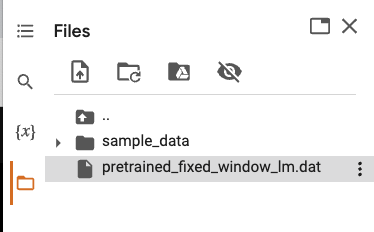

Now that we have the model weight downloaded, we can instantiate a model with these parameters. This will work in two steps. 
 - First we will need to create a new model (with potentially random weights). 
 - Then, we will copy the parameter values to the model using `load_state_dict()` function. You can read more about this function [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).  

In [ ]:
# let's now instantiate our model 
embedding_dim = 256
hidden_size = 1048
num_blocks = 4
dropout_p = 0.2


pretrained_model = NPLM(tokenizer.vocab_size, embedding_dim, local_window_size, hidden_size, num_blocks, dropout_p)
pretrained_model.to(device)

checkpoint = torch.load('/content/pretrained_fixed_window_lm.dat', map_location=torch.device('cuda:0'))

pretrained_model.load_state_dict(checkpoint)

Note that parameters should match the architecture. For example, if `num_blocks ` was set to `3` instead of `4`, you'd see an error message from Pytorch. 


How good is our model? Let's evaluate it on the dev set! 

In [ ]:
dev_loss, dev_ppl = evaluate(dev_loader, pretrained_model, criterion, device)
print("Development perplexity {}...".format(dev_ppl))

This is pretty good but certainly can be further improved! Can you beat it? 

## **Extra credit:** If you manage to improve the perplexity of the perplexity  by **at least** 10 points (better training or architecture hyperparams, etc.), you'll get 5 extra credit. Each additional 10-point improvement in perplexity will be awarded an additional 5 units of extra credit. So in an ideal world, if you reudce the PPL to 1, you'll get 125 extra credit points!!! 🤡

# Generation from Language Models 

Now that we have trained our language model, how can we sample from it? 

Here are two strategies we will try to generate each word. 
(1) We can select the most probable words (argmax). 
<div>
<img src="https://self-supervised.cs.jhu.edu/sp2023/files/argmax_sampling.webp" width="580"/>
</div>


(2) We can sample from the distribution proportional to word probablities. Words with higher probabilities will be more likely to be sampled. 
However, we also have an option of filter the low-probability tokens, and instead retaining tokens that constitute `top_p` probability.  
<div>
<img src="https://self-supervised.cs.jhu.edu/sp2023/files/p_sampling.webp" width="580"/>
</div>


Let's give implement these! 
 

In [ ]:
from transformers import top_k_top_p_filtering


def generate_text(prompt, model, top_p, maximum_generation = 100): 

  # tokenize the text and turn it into indices 
  tokenized_prompt = tokenizer.tokenize(prompt)
  tokenized_prompt_ids = tokenizer.convert_tokens_to_ids(tokenized_prompt) 

  pred = 0
  count = 0
  while count < maximum_generation:
      # select the tokens in the window 
      new_input = torch.tensor(tokenized_prompt_ids[-local_window_size:]).to(device)
      
      # compute model output 
      output = model(new_input)
      
      if top_p:   
        # filter the top_p generations 
        output = top_k_top_p_filtering(output, top_p=top_p)
        probs = F.softmax(output, dim=-1)
        pred = torch.multinomial(probs, num_samples=1).squeeze(1)
      else: 
        # greedy decoding 
        pred = torch.argmax(output).item()
    
      tokenized_prompt_ids.append(pred)
      count += 1
  
  # turn token-ids to their strings
  subwords = tokenizer.convert_ids_to_tokens(tokenized_prompt_ids)

  # turn sub-words into a sentence
  generation = ""
  for token in subwords:
      if token.startswith("##"):
        generation += token.replace("##", "")
      else: 
        generation += " " + token
  print(f"Generated text: {generation}")


In [ ]:
prompt = "The best perks of living on the east"


# greedy decoding 
print(" -------- try #1 --------")
generate_text(prompt=prompt, model=pretrained_model, top_p=None)

# sampling with p=0.0; note this is equivalent to the greedy search 
print(" -------- try #2 --------")
generate_text(prompt=prompt, model=pretrained_model, top_p=0.0)

# sampling with p=0.3
print(" -------- try #3 --------")
generate_text(prompt=prompt, model=pretrained_model, top_p=0.3)

# sampling with p=1.0 
print(" -------- try #5 --------")
generate_text(prompt=prompt, model=pretrained_model, top_p=1.0)

## **Question 5:** Compare the output of the above generations? Which one is your favorite. Explain why this choice of sampling leads to better text generation. 

Obviously, these generations are nowhere close to perfect and there are various reasons for that.  First, our model is quite small compared to many modern NLP models. The data we use is small as it is just a fractin of Wikipedia, while modern NLP models are trained on much larger data. So, this is really not bad at all! 

# Obama LM

Just for fun, we will tune our language model on Obama's speeches to see if our model can immitate Obama's style of speaking! 

<div>
<img src="https://media-cldnry.s-nbcnews.com/image/upload/newscms/2017_02/1861016/170110-obama-farewell-rhk.jpg" width="520"/>
</div>







Let's download a collection of Obama's speeches: 

In [ ]:
base_url = "https://self-supervised.cs.jhu.edu/sp2023/files/"
dataset = load_dataset("text", data_files={'train': base_url + "obama-speeches-train.txt", 'dev':  base_url + "obama-speeches-test.txt"})
obama_train_dataset = dataset['train']
obama_dev_dataset = dataset['dev']

And pre-process them the way we pre-processed the Wikipedia data. 

In [ ]:
# creating training and dev dataset
local_window_size = 6
x_train, y_train = preprocess_data(obama_train_dataset, local_window_size)
x_dev, y_dev = preprocess_data(obama_dev_dataset, local_window_size)

  
print(x_train.shape)
print(y_train.shape)
print(x_dev.shape)
print(y_dev.shape)

And turn it into batches: 

In [ ]:
batch_size = 4096

obama_train = np.concatenate((x_train, y_train), axis=1)
obama_dev = np.concatenate((x_dev, y_dev), axis=1)

# Use PyTorch's internal functions for loading data and iterating over it 
# See more details here: https://pytorch.org/docs/stable/data.html 
from torch.utils.data import DataLoader 

obama_train_loader = DataLoader(obama_train, batch_size = batch_size)
obama_dev_loader = DataLoader(obama_dev, batch_size = batch_size)

While we can train a new model from scratch on this data, the Obama data is small and hence, training a new model is not going to work. 
Instead we will use our pretrained model on Wikipedia and do additional training on Obama speeches: 

In [ ]:
trainer(pretrained_model, obama_train_loader, obama_dev_loader, num_epoch = 10, lr=1e-4, decay=1.0, criterion=criterion)

Now, let's try to generate from this model. 

In [ ]:
generate_text("Hi, everybody. The obamacare will ", model, top_p=0.1)

Huh ... interesting! Probably not the best Obama LM we will build, but not a bad start. We will be much better ones in the coming lectures. 

# Building an N-Grams LMs

We can also build an n-gram language model and compare it to our neural model. 
As a reminder, an n-gram language model is a statistical language model that predicts the next word in a sequence based on the preceding n-1 words. In other words, it models the probability distribution of sequences of words, where each sequence is represented as a set of n consecutive words, called an n-gram. The model is trained on a large corpus of text to learn the probabilities of observing different n-grams in the language.

For example, in a bigram language model (n=2), the model would estimate the probability of observing each bigram (two-word sequence) in the language based on the training data. Given a sequence of words, the model would predict the next word in the sequence based on the preceding word. In a trigram language model (n=3), the model would predict the next word based on the preceding two words, and so on.


It's actually easy to implement n-grams on a small scale. 
Here is our implementation



In [ ]:
from collections import Counter, defaultdict # we will using "Counter" data structure for counting word co-occurences 

def create_ngrams(data, n): 
  ngrams = Counter()
  ngram_context = Counter()
  word_candidate = defaultdict(list)


  for paragraph in tqdm(data['text']):
      
      # if the paragraph is too short, skip it 
      if len(paragraph) < 3: 
        continue 
        
      # iterate over sentences given by our sentence splitter 
      for sentence in splitter.split(paragraph): 
        
        # tokenize the words in the our sentence 
        tokens = tokenizer.tokenize(sentence)
        # tokenIds = tokenizer.convert_tokens_to_ids(tokens)

        # drop short sentences
        if len(tokens) < local_window_size + 1: 
          break  
        
        for idx, _ in enumerate(tokens): 
          
          if idx + n >= len(tokens): 
              # have already traversed all of the sentence 
              break

          ngrams[tuple(tokens[idx: idx+n])] += 1
          ngram_context[tuple(tokens[idx: idx+n-1])] += 1
          word_candidate[tuple(tokens[idx: idx+n-1])].append(tokens[idx+n-1])

  # calculate tuple probability
  word_pred = {}
  for key, value in word_candidate.items():
      scores = []
      for i in value:
          tmp_key = list(key)
          tmp_key.append(i)
          scores.append(ngrams[tuple(tmp_key)]/ngram_context[key])
      word_pred[key] = value[np.argmax(scores)]
  return word_pred

In [ ]:
# use a subset to compute the 3-grams 
# even though this is a subset of the data, and only done for 3-grams, 
# it will take around 1-2 minutes. 
# note that this process is done on CPUs (it's all counting)
word_pred = create_ngrams(train_dataset[:100000], n=3) 

In [ ]:
# generate
n = 3 
initial = tuple("The album by".lower().split())
res = list(initial)
maximum = 100
stop = "."
pred = ""
count = 0
while count < maximum and pred != ".":
    pred = word_pred[tuple(res[-n+1:])]
    res.append(pred)
    count += 1
print(" ".join(res))

## **Extra credit:** (5 points) write a modified implementation of n-gram LM to do p-sampling generation (e.g., p=0.3). 

# Improving Classification with Rich Features of LMs 

Remember we implemented a sentiment classifier with Word2Vec embeddings? 
We can repeat the same idea, but with richer features we have can obtain from our language model and get a better a classifir. We will not do that now since we have already done quite a bit already by now. However, we will revisit the idea in our future language models. 

### Congratulations!
You've come to the end of this assignment! 
